# Modelling Concerns About Personal Information with Structural Equation Modelling


## 1) Data Operations

I first start with loading necessary packages and declaring required magic commands for this analysis.

In [52]:
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import semopy as sm

#inline plotting for matplotlib in jupyter
%matplotlib inline

#to reload easily
%reload_ext autoreload
%autoreload 2

# I like ggplot style
plt.style.use('ggplot')

What I am doing below is defining the theoretical scope of this analysis.

Unlike common practice The "column_names" list is containing the names of the variables that I am going to use in this analysis. In the next chunk of code, I will be inserting this column into stata reader to make it return only these variables.

This is not an obligation. Especially for doing purely exploratory work, keeping the whole data might be beneficial. However, as you might realize by now, the designers of the survey made really terrible choice of variable naming. These are just some random numbers and letters. One can easily make mistakes working with them.

In [2]:
# Column names that I want to keep
column_names = (["Q999","Q91_w7","Q92_w4","Q94_w4",
                 "Q93_w4","Q97_w4", "Q201A_w7","Q201B_w7",
                 "Q201C_w7","Q201D_w7","Q201E_w7","Q60A_w4","Q60B_w4",
                 "Q60C_w4","Q60D_w4","Q60E_w4","Q60F_w4","Q60G_w4",
                 "Q71A_w4","Q71B_w4","Q71C_w4","Q71D_w4","Q72A_w4",
                 "Q72B_w4","Q72C_w4","Q72D_w4","Q73A_w4","Q73B_w4",
                 "Q73C_w4","Q73D_w4","Q74A_w4","Q74B_w4","Q74C_w4",
                 "Q74D_w4","Q75A_w4","Q75B_w4","Q75C_w4","Q75D_w4"])


I am using pandas' stata reader. The important point when working with .dta files is you have both numeric versions and labelled versions of the data. In the labelled version one can see questions that are asked in the survey as well as the answers in human language. Whereas the numeric version only contains the numerical representation of the survey. So in order to understand what we are working with, we have to read both versions of the data. The iterator argument in the reader function allows us to achieve this.

Also, as I mentioned, I passed the column_names here into the function to make stata reader only read the columns in the file that are matching the list.

In [3]:
# Calling the stata reader object
reader = (pd.read_stata(
    'df2.dta',
    columns=column_names,
    iterator=True)
    )

In [4]:
# Reading the labels of the rows
value_labels = reader.value_labels()

In [5]:
# Reading the column labels.
variable_labels = reader.variable_labels()

Below I am calling stata reader's read method with convert categoricals argument as False. This makes stata reader skip the labels and only return the numeric version of the data.

In [6]:
df = reader.read(convert_categoricals=False)

So, below is a random sample of 5 rows from our dataset. As it stands, it's impossible to make sense of it. But with the help of value labels and variable labels we can make sense of it without referring to the questionnaire .pdf that added to this repo back and forth.

In [7]:
df.sample(5)

,Q999,Q91_w7,Q92_w4,Q94_w4,Q93_w4,Q97_w4,Q201A_w7,Q201B_w7,Q201C_w7,Q201D_w7,...,Q73C_w4,Q73D_w4,Q74A_w4,Q74B_w4,Q74C_w4,Q74D_w4,Q75A_w4,Q75B_w4,Q75C_w4,Q75D_w4
6725,3.0,NaN,34.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,...,5.0,5.0,6.0,6.0,2.0,2.0,2.0,2.0,6.0,6.0
1598,3.0,1.0,67.0,3.0,27.0,4.0,6.0,2.0,2.0,6.0,...,7.0,6.0,6.0,6.0,2.0,4.0,2.0,3.0,5.0,4.0
1195,3.0,2.0,36.0,3.0,24.0,5.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3612,1.0,NaN,75.0,5.0,2.0,3.0,NaN,NaN,NaN,NaN,...,5.0,4.0,4.0,5.0,5.0,6.0,3.0,3.0,5.0,5.0
5064,2.0,NaN,54.0,3.0,9.0,2.0,NaN,NaN,NaN,NaN,...,3.0,2.0,5.0,2.0,3.0,5.0,3.0,3.0,6.0,3.0


In [8]:
# showing the definitions of first three questions
list(variable_labels.items())[:3]

[('za_nr', 'ZA Study Number'),
 ('version', 'GESIS Archive Version'),
 ('doi', 'Digital Object Identifier')]

In [9]:
# showing the value labels of first 3 questions
list(value_labels.items())[:3]

[('noyes', {0: ' No', 1: 'Yes'}),
 ('countryX',
  {0: ' Netherlands',
   1: 'Denmark',
   2: 'Germany',
   3: 'Hungary',
   4: 'Spain',
   6: 'Czech Republic',
   7: 'France',
   8: 'Greece',
   9: 'Poland',
   10: 'Sweden'}),
 ('OCCUPATION',
  {1: 'Legislator, Senior Official, or Manager',
   2: 'Professional (engineer, doctor, teacher, clergy, etc.)',
   3: 'Technician or Associate Professional (inspector, finance dealer, etc.)',
   4: 'Clerk (secretary, cashier, etc.)',
   5: 'Service or sales worker (cook, travel guide, shop salesperson, etc.)',
   6: 'Agricultural or fishery worker (vegetable grower, livestock producer, etc.)',
   7: 'Craft or trades worker (carpenter, painter, jewelry worker, butcher, etc.)',
   8: 'Plant/machine operator or assembler (equipment assembler, sewing-machine operato',
   9: 'Elementary worker (street food vendor, shoe cleaner, etc.)',
   10: 'Armed forces (government military)'})]

These two will aid us understanding what we are working with.
The first challenge arises here. For some reason variable_labels and value_labels are returning the whole dataset rather than the list of columns that I declared. I want the variable labels of the columns that I declared, not the whole variables. So in order to get that, I will use a lambda function that go through variable labels dictionary and preserve elements only when the key is matching my column_names list.

In [10]:
# Function to preserve the elements that are matching
dict_filter = lambda var, names: dict([ (element,var[element]) for element in var if element in names ])

# Apply the filter to our dataset
labels = dict_filter(variable_labels, column_names)

Above code achieved what I aimed for. As I feel more comfortable with dataframes rather than dictionaries, I would like to make a neat data frame of variable names and questions that they are referring to. For that one, I loop over the dictionary items and construct a dataframe.

In [11]:
variable = []
question = []
for key, value in labels.items():
    variable.append(key)
    question.append(value)

# Convert the dictionary to pandas dataframe
map_df = pd.DataFrame({"variable":variable, "question":question})

In [12]:
# Result
map_df

,variable,question
0,Q91_w7,Q91: Gender
1,Q201A_w7,Q201a: Privacy concern (I am concerned that my...
2,Q201B_w7,Q201b: Privacy concern (When I visit websites ...
3,Q201C_w7,Q201c: Privacy concern (I am afraid that my pe...
4,Q201D_w7,Q201d: Privacy concern (I am concerned that my...
5,Q201E_w7,Q201e: Privacy concern (I am concerned that my...
6,Q92_w4,Q92: Age
7,Q93_w4,Q93: region
8,Q94_w4,Q94: Urbanization
9,Q71A_w4,Q71a IPIP Have a vivid imagination


After creating this reference data frame, now I would like to get rid of uninformative variable names by replacing them with the ones that are more easily recognisable. So I constructed the dictionary below for this purpose.

The variable naming that I chose is actually rooted in the theory behind the survey design. If you check the questions above, you might realize that some set of questions are actually really close to each other in terms of what they are intended to measure. This is a latent variable construct. For instance, the questions that I renamed with open_ prefix are specially designed to measure the opennes of respondents personality. Similarly agrb_ prefix refers to set of questions intended to measure the respondents agreeableness. Those latent constructs together form the Big-Five personality traits taxonomy. Similar latent construct story holds true for pi_ prefix. With that set of questions, the concerns about personal information are measured.

The questions measuring trust in political institutions can also be grouped together under one latent construct or they can be viewed distinctly. This is a design choice. In this analysis I choose to group them under a latent construct for two reasons. First, from the theoretical perspective, I don't want to make distinct hypotheses about each different item. I am interested in trust in political institutions altogether. Second, even if the one chooses to model the trust for each institutions seperately in a regression model, this can cause multicollinearity because most of the time they yield correlated results contional on something.

In [13]:
column_map = ({"Q999": "country", "Q91_w7": "gender",
               "Q92_w4": "age", "Q94_w4":"urbanization",  "Q93_w4": "region",
               "Q97_w4": "income", "Q201A_w7": "pi_misuse",
               "Q201B_w7": "pi_track", "Q201C_w7": "pi_safety", "Q201D_w7": "pi_share",
               "Q201E_w7": "pi_stranger", "Q60A_w4": "trst_prl", "Q60B_w4": "trst_pol",
               "Q60C_w4": "trst_prt", "Q60D_w4": "trst_leg", "Q60E_w4": "trst_plc",
               "Q60F_w4": "trst_gov", "Q60G_w4": "trst_eu", "Q71A_w4": "open_a",
               "Q71B_w4": "open_b", "Q71C_w4": "open_c", "Q71D_w4": "open_d",
               "Q72A_w4": "cons_a", "Q72B_w4": "cons_b", "Q72C_w4": "cons_c",
               "Q72D_w4": "cons_d", "Q73A_w4": "extr_a", "Q73B_w4": "extr_b",
               "Q73C_w4": "extr_c", "Q73D_w4": "extr_d", "Q74A_w4": "agrb_a",
               "Q74B_w4": "agrb_b", "Q74C_w4": "agrb_c", "Q74D_w4": "agrb_d",
               "Q75A_w4": "neur_a", "Q75B_w4": "neur_b", "Q75C_w4": "neur_c",
               "Q75D_w4": "neur_d"})

In [14]:
df.rename(columns=column_map, inplace=True)

Great, now everything suits my liking.  Now we can explore what stories we have within.

In [15]:
df.sample(5)

,country,gender,age,urbanization,region,income,pi_misuse,pi_track,pi_safety,pi_share,...,extr_c,extr_d,agrb_a,agrb_b,agrb_c,agrb_d,neur_a,neur_b,neur_c,neur_d
4008,1.0,NaN,21.0,2.0,2.0,4.0,NaN,NaN,NaN,NaN,...,2.0,2.0,6.0,5.0,2.0,1.0,2.0,2.0,4.0,4.0
1158,3.0,1.0,26.0,1.0,24.0,4.0,2.0,2.0,3.0,2.0,...,6.0,6.0,3.0,3.0,6.0,4.0,4.0,6.0,7.0,7.0
5402,2.0,NaN,41.0,3.0,13.0,4.0,NaN,NaN,NaN,NaN,...,4.0,6.0,5.0,4.0,1.0,1.0,4.0,2.0,6.0,4.0
2002,4.0,2.0,42.0,4.0,35.0,4.0,7.0,7.0,7.0,7.0,...,4.0,3.0,7.0,6.0,2.0,1.0,4.0,7.0,1.0,2.0
5351,2.0,NaN,53.0,2.0,21.0,5.0,NaN,NaN,NaN,NaN,...,6.0,6.0,6.0,5.0,2.0,4.0,4.0,3.0,4.0,3.0


The first thing I would like to check is the shape of the data frame. We are talking about 11k observations with 38 variables. But I can see lots of NaNs in the dataframe. In the following lines I would like to make a report of missing values in order to decide my strategy to tackle it.

In [16]:
df.shape

(11186, 38)

Below is the set of variables that are containing missing values. Remaining 31 variables are not containing any missing values. But the vital question is what is the amount of missing values? Just to check that I will first acquire percentage of valid values in all columns. The count() method counts the valid observations in the dataframe and len() returns the number of total observations regardless of their status. By dividing valid ones to the total length, I acquire the percentage of valid observations.

In [17]:
list(df.columns[df.isnull().mean() != 0])

['gender',
 'region',
 'pi_misuse',
 'pi_track',
 'pi_safety',
 'pi_share',
 'pi_stranger']

In [18]:
# Percentage of valid observations for all variables
report_observations = pd.DataFrame(df.count() / len(df),columns=["percentage"]).\
    reset_index().\
    rename(columns={"index":"variable"})

In [19]:
# Percentage of valid observations within the subset of columns that contain missing values
report_missing = report_observations[report_observations.percentage < 1]

In [20]:
report_missing

,variable,percentage
1,gender,0.198373
4,region,0.981316
6,pi_misuse,0.198373
7,pi_track,0.198373
8,pi_safety,0.198373
9,pi_share,0.198373
10,pi_stranger,0.198373


Well, as concerns about personal information is my latent target variable in this analysis, it saddens me to see huge chunk of missing values are actually on those items that are measuring this latent variable. Let's make a sad visualisation of structure of missing values in this dataset.

<BarContainer object of 7 artists>

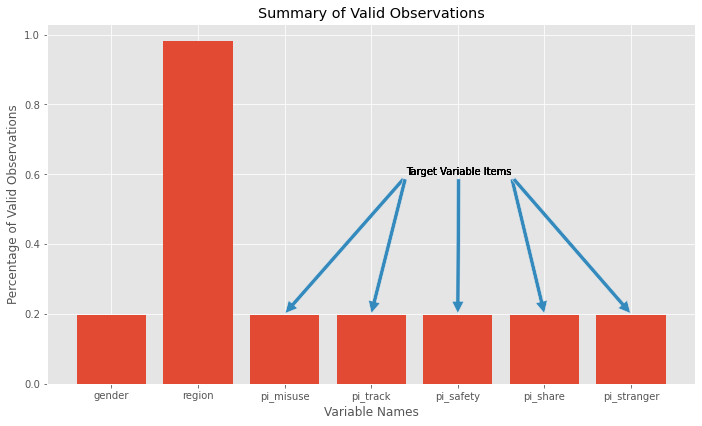

In [21]:
fig_1 = plt.figure(figsize=(9,5))
axes_1 = fig_1.add_axes([0,0,1, 1])
axes_1.set_title("Summary of Valid Observations")
axes_1.set_xlabel("Variable Names")
axes_1.set_ylabel("Percentage of Valid Observations")
for i in range(2,7):
    axes_1.annotate("Target Variable Items", xy=(i,0.2), xytext=(3.4,0.6,),
                    arrowprops =dict( shrink=0.005))
axes_1.bar(report_missing["variable"], report_missing["percentage"])

Since the items measuring concerns about personal information has the most missing values, that makes not much sense to consider other missing data strategies than dropping the all cases. The reason is, let's say, even if I use missing data imputation methods on other variables, the target variable would be still containing missing values.

In [22]:
df.dropna(subset=['pi_misuse', 'pi_track', 'pi_safety', 'pi_share', 'pi_stranger',], how="any", inplace=True)

In [23]:
df.shape

(2219, 38)

In [24]:
df.columns

Index(['country', 'gender', 'age', 'urbanization', 'region', 'income',
       'pi_misuse', 'pi_track', 'pi_safety', 'pi_share', 'pi_stranger',
       'trst_prl', 'trst_pol', 'trst_prt', 'trst_leg', 'trst_plc', 'trst_gov',
       'trst_eu', 'open_a', 'open_b', 'open_c', 'open_d', 'cons_a', 'cons_b',
       'cons_c', 'cons_d', 'extr_a', 'extr_b', 'extr_c', 'extr_d', 'agrb_a',
       'agrb_b', 'agrb_c', 'agrb_d', 'neur_a', 'neur_b', 'neur_c', 'neur_d'],
      dtype='object')

Even though the structural equation modelling package, semopy, will let me define the latent constructs, I still create additive indices for each latent construct. The reason I am doing this is to make the exploration much easier. Considering the fact that tha latent variables are measured by sub-items that creates a problem of dimensions. In order to reduce the number of plots that I have to make I will lower down the number of dimensions that I work with by the help of those indeces.

In [25]:
df["openness"] = (df["open_a"] + df["open_b"] + df["open_c"]+ df["open_d"]) / 4
df["conscientiousness"] = (df["cons_a"] + df["cons_b"] + df["cons_c"]+ df["cons_d"]) / 4
df["agreeableness"] = (df["agrb_a"] + df["agrb_b"] + df["agrb_c"]+ df["agrb_d"]) / 4
df["extraversion"] = (df["extr_a"] + df["extr_b"] + df["extr_c"]+ df["extr_d"]) / 4
df["neuroticism"] = (df["neur_a"] + df["neur_b"] + df["neur_c"]+ df["neur_d"]) / 4
df["pi_concerns"] = (df["pi_misuse"] + df["pi_track"] + df["pi_share"]+ df["pi_safety"] + df["pi_stranger"])  / 5
df["trust_in_inst"] = (df["trst_leg"] + df["trst_eu"] + df["trst_gov"]+ df["trst_plc"] + df["trst_pol"]+ df["trst_prl"] + df["trst_prl"]) / 7

In [26]:
df.head()

,country,gender,age,urbanization,region,income,pi_misuse,pi_track,pi_safety,pi_share,...,neur_b,neur_c,neur_d,openness,conscientiousness,agreeableness,extraversion,neuroticism,pi_concerns,trust_in_inst
0,1.0,2.0,34.0,1.0,5.0,2.0,5.0,5.0,5.0,5.0,...,4.0,4.0,2.0,3.25,4.25,3.75,3.25,3.25,5.0,2.428571
1,1.0,1.0,34.0,3.0,4.0,2.0,1.0,7.0,1.0,1.0,...,1.0,7.0,4.0,5.50,4.00,4.75,4.00,4.75,2.2,7.000000
2,1.0,1.0,65.0,3.0,5.0,3.0,4.0,5.0,4.0,4.0,...,5.0,6.0,4.0,3.00,4.50,4.00,4.00,4.75,4.2,4.285714
3,1.0,1.0,32.0,3.0,4.0,4.0,6.0,7.0,5.0,5.0,...,3.0,6.0,3.0,2.75,5.00,4.25,3.50,3.75,5.6,3.285714
4,1.0,1.0,55.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,...,2.0,6.0,5.0,2.75,5.00,3.25,3.75,4.00,5.0,3.285714


In this analysis I will not use categorical variables as my predictors in the modelling section. However, I still want to convert these two categorical variables into their proper types. I keep them ready, in case I want to explore further research avenues by involving these two into my models.

In [27]:
df.country.replace({1: "Denmark", 2: "Germany", 3:"Hungary", 4:"Spain"}, inplace=True)

In [28]:
df.urbanization.replace({1: 'Big City',
                         2: 'Outer Big City',
                         3: 'Town/Small City',
                         4: 'Village',
                         5: 'Farm'}, inplace=True)

## 2) Exploration
In this section I would like to explore the relationships between certain variables. I personally don't find it useful to make bunch heatmap of correlations. To me exploration means more than that. At each level certain care must be given.

First thing that we have to keep in mind is that the most of the variables are discrete variables. This makes plotting and exploration phase little bit tricky. If you make a plot of discrete variable against another discrete variable, then what you'll end up with will not be informative plot. Let me quickly demonstrate the problem


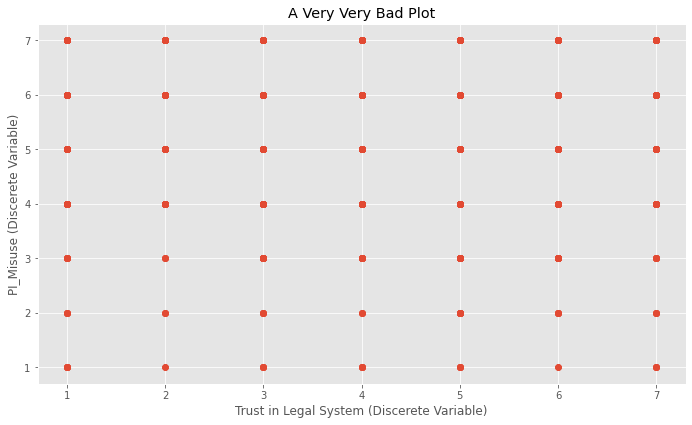

In [29]:
fig = plt.figure(figsize=(9,5))
axes = fig.add_axes([0,0,1, 1])
axes.set_title("A Very Very Bad Plot")
axes.set_ylabel("PI_Misuse (Discerete Variable)")
axes.set_xlabel("Trust in Legal System (Discerete Variable)")
plt.scatter(df["trst_leg"], df["pi_misuse"])

For this reason, when working with discrete variables, directly plotting variables against each other is not a smart idea. We need some transformations. What I am going to do during the exploration phase is, I just simply keep my X variable as is, while replacing Y with mean of the Y for each value in X. Following the example above, for each level in "trst_leg", I will calculate the mean of "pi_misuse" and plot them. Below plot is how it looks in action

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/example_plot.png


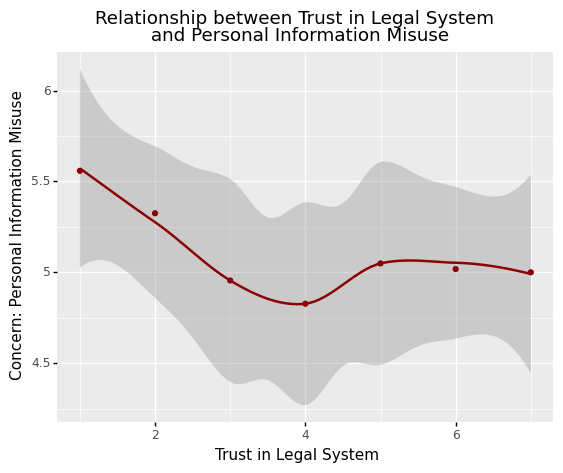

<ggplot: (8778348214020)>

In [67]:
#Grouping by trst leg values and replacing pi_misuse with the mean of it
mask = df.groupby("trst_leg")["pi_misuse"].mean().reset_index().copy()
# create the plot
example_plot = (
        ggplot(mask,
               aes(x="trst_leg", y="pi_misuse")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color= "darkred") +
        xlab("Trust in Legal System") +
        ylab("Concern: Personal Information Misuse") +
        ggtitle("Relationship between Trust in Legal System \n and Personal Information Misuse")
                )
# save the plot
ggplot.save(self= example_plot,
            filename="example_plot.png",
            path="plots/")
# display the plot
example_plot

However, it is important to notice that when we are applying this transformation we are basically getting rid of the variation in the data by reducing the whole distribution of Y on any single point of X into a single statistic. This transformation can help us get an idea about direction of the relationship between two discrete variables. It shouldn't be used for jumping on over confident conclusions about the functional form of the relationship.

I use plotnine package as it allows us to use almost all capabilities of R's legendary Ggplot package. The most beneficial part of this library is that it has super easy curve fitting function. As far as I am aware, seaborn also has some curve fitting functionality however plotnine's layered grammar of graphics is much easy to customise.

A note for udacity reviewer: I know it looks like I am trying to cheat by using a package that relies on R's grammar. But this is still a python package. It doesn't use rpy2 or any sort of R to Python converter. Everything in this package is pure python. Yes, by using this package I am not leaving my comfort zone however plotnine is more capable than seaborn or plotly and it is hell of a lot quicker to create visualisations than matplotlib. Also, on the first plot, I demonstrated that I can use matplotlib whenever it needs :)

### 2.1) Demographic Variables on Personal Information Concerns

I will plot the demographics here. Demographics are not part of my core three research questions but they are almost always included in any analysis as control variables.

#### 2.1.A) Age on PI

The first demographic variable is Age. Seems like age is "associated" with increase in concerns about personal information up to around 70 years. Then the slope turns negative. However, it's important that we shouldn't make any causal conclusions here. It might be cohort or generation effects. Currently I am 30 years old and this plot is not saying that when I get to 70 my concerns about personal information is expected to increase.

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/age_vs_pi.png


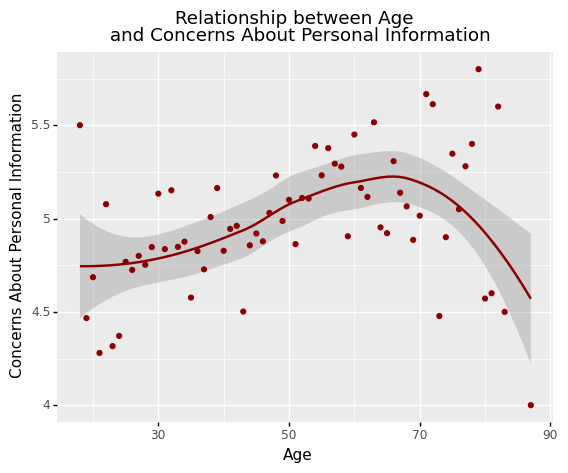

<ggplot: (8778349859491)>

In [69]:
mask = df.groupby("age")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
age_vs_pi = (
        ggplot(mask,
               aes(x="age", y="pi_concerns")) +
        geom_smooth(method="loess",
                    se=True,
                    color="darkred") +
        geom_point(color="darkred") +
        xlab("Age") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship between Age \n and Concerns About Personal Information")
            )
# save the plot
ggplot.save(self=age_vs_pi,
            filename="age_vs_pi.png",
            path="plots/")
# display the plot
age_vs_pi

#### 2.1.B) Country on PI
Average personal information concerns looks very similar in each country. Spain and Germany scoring higher.

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/country_vs_pi.png


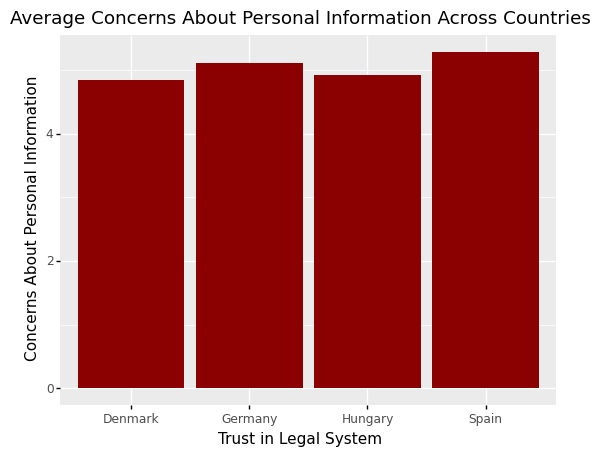

<ggplot: (8778347131772)>

In [77]:
mask = df.groupby("country")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# Create the plot
country_vs_pi = (
        ggplot(mask,
               aes(x="country", y="pi_concerns")) +
        geom_col(stat="identity", fill="darkred") +
        xlab("Trust in Legal System") +
        ylab("Concerns About Personal Information") +
        ggtitle("Average Concerns About Personal Information Across Countries")
                )
# save plot
ggplot.save(self=country_vs_pi,
            filename="country_vs_pi.png",
            path="plots/")

# display the plot
country_vs_pi

#### 2.1.C) Income on PI


/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/income_vs_pi.png


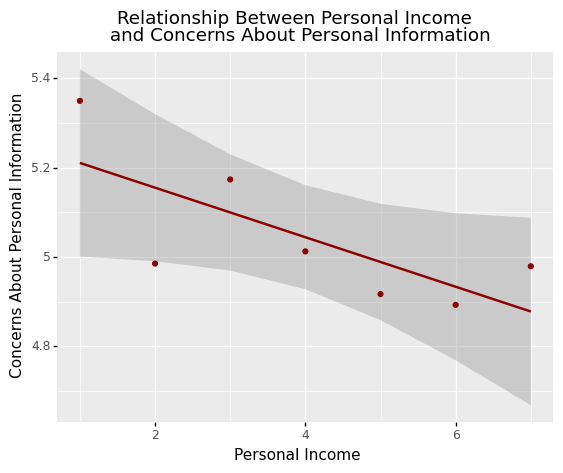

<ggplot: (8778350633322)>

In [71]:
mask = df.groupby("income")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
# changing dtype to int is necessary for this plot
mask.income = mask.income.astype("int")

# create the plot
income_vs_pi = (
        ggplot(mask,
               aes(x="income", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Personal Income") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Personal Income \n and Concerns About Personal Information")
                )
ggplot.save(self=income_vs_pi,
            filename="income_vs_pi.png",
            path="plots/")

# display the plot
income_vs_pi


/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/income_vs_pi_gendered.png


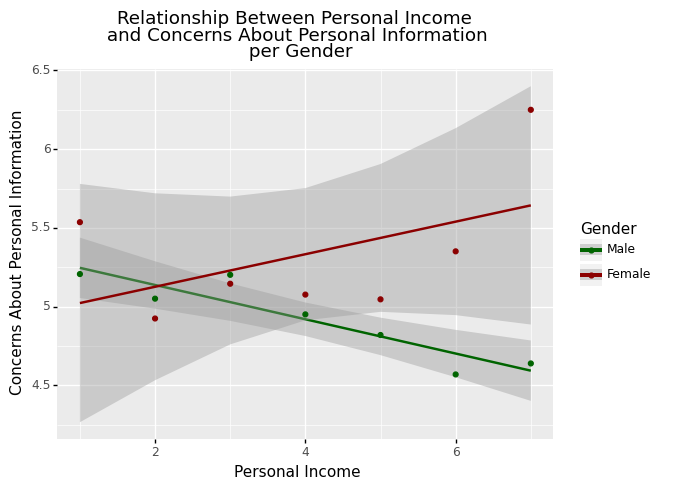

<ggplot: (8778347975343)>

In [72]:
mask = df.groupby(["income", "gender"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
mask.income = mask.income.astype("int")

# create the plot
income_vs_pi_gendered = (
    ggplot(mask,
           aes(x="income", y="pi_concerns", color="factor(gender)")) +
    geom_smooth(method="lm", se=True) +
    geom_point() +
    xlab("Personal Income") +
    ylab("Concerns About Personal Information") +
    scale_color_manual(name = "Gender",
                       values=["darkgreen", "darkred"],
                       labels=["Male", "Female"]) +
    ggtitle("Relationship Between Personal Income \n and Concerns About Personal Information \n per Gender")
                        )
# save the plot
ggplot.save(self=income_vs_pi_gendered,
            filename="income_vs_pi_gendered.png",
            path="plots/")

# display the plot
income_vs_pi_gendered




#### 2.1.D) Urbanization on PI


/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/urbanization_vs_pi.png


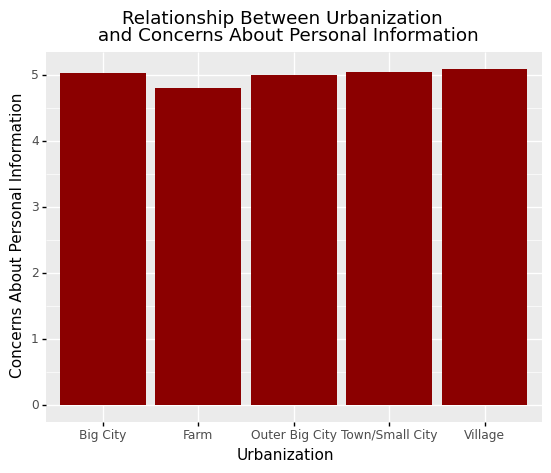

<ggplot: (8778367504348)>

In [76]:
mask = df.groupby(["urbanization"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
urbanization_vs_pi = (
        ggplot(mask,
               aes(x="urbanization", y="pi_concerns")) +
        geom_col(stat="identity", fill="darkred") +
        xlab("Urbanization") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Urbanization \n and Concerns About Personal Information")
                     )
# save the plot
ggplot.save(self=urbanization_vs_pi,
            filename="urbanization_vs_pi.png",
            path="plots/")

# display the plot
urbanization_vs_pi


### 2.2) Trust In Institutions on Concerns About Personal Information

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/trst_inst_vs_pi.png


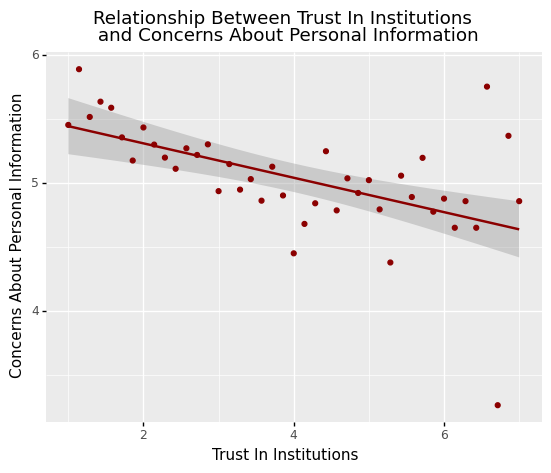

<ggplot: (8778350613827)>

In [78]:
mask = df.groupby(["trust_in_inst"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
trst_inst_vs_pi = (
        ggplot(mask,
               aes(x="trust_in_inst", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Trust In Institutions") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Trust In Institutions \n and Concerns About Personal Information")
                  )
# save the plot
ggplot.save(self=trst_inst_vs_pi,
            filename="trst_inst_vs_pi.png",
            path="plots/")

# display the plot
trst_inst_vs_pi


### 2.3) Personality Traits on PI
#### 2.3.A) Openness on PI

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/open_vs_pi.png


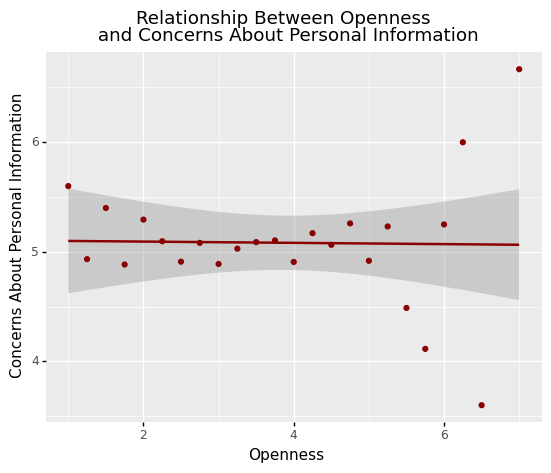

<ggplot: (8778345798057)>

In [79]:
mask = df.groupby(["openness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
open_vs_pi = (
        ggplot(mask,
               aes(x="openness", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Openness") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Openness \n and Concerns About Personal Information")
)
# save the plot
ggplot.save(self=open_vs_pi,
            filename="open_vs_pi.png",
            path="plots/")

# display the plot
open_vs_pi


#### 2.3.B) Extraversion on PI

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/extr_vs_pi.png


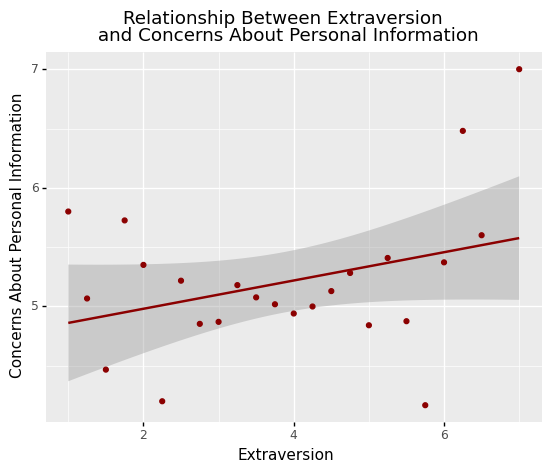

<ggplot: (8778349493941)>

In [80]:
mask = df.groupby(["extraversion"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
extr_vs_pi = (
        ggplot(mask,
               aes(x="extraversion", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Extraversion") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Extraversion \n and Concerns About Personal Information")
             )
# save the plot
ggplot.save(self=extr_vs_pi,
            filename="extr_vs_pi.png",
            path="plots/")

# display the plot
extr_vs_pi


#### 2.3.C) Neuroticism on PI


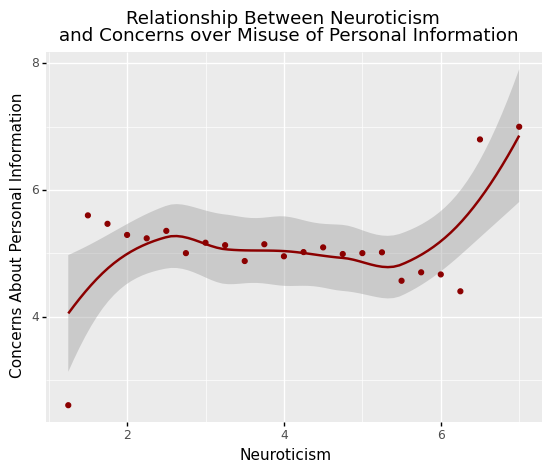

<ggplot: (8778346563859)>

In [39]:
mask = df.groupby(["neuroticism"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
(
        ggplot(mask,
               aes(x="neuroticism", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Neuroticism") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Neuroticism \n and Concerns over Misuse of Personal Information")
)


#### 2.3.D) Aggreableness on PI

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/agrb_vs_pi.png


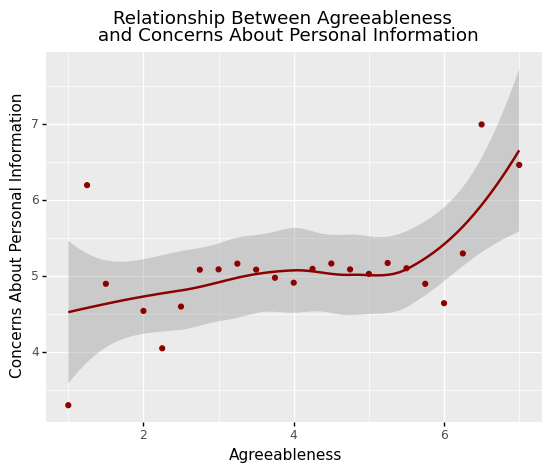

<ggplot: (8778346983503)>

In [81]:
mask = df.groupby(["agreeableness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
agrb_vs_pi = (
        ggplot(mask,
               aes(x="agreeableness", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Agreeableness") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Agreeableness \n and Concerns About Personal Information")
             )
# save the plot
ggplot.save(self=agrb_vs_pi,
            filename="agrb_vs_pi.png",
            path="plots/")

# display the plot
agrb_vs_pi

#### 2.3.E) Conscientiousness on PI

/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tugberk/opt/anaconda3/envs/Medium_Post/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: plots/cons_vs_pi.png


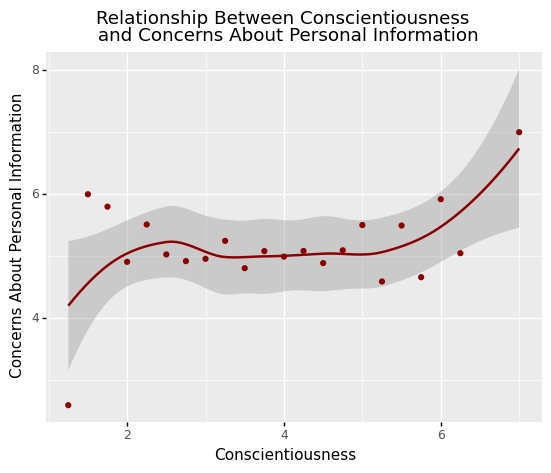

<ggplot: (8778345908947)>

In [82]:
mask = df.groupby(["conscientiousness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

#create the plot
cons_vs_pi = (
        ggplot(mask,
               aes(x="conscientiousness", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Conscientiousness") +
        ylab("Concerns About Personal Information") +
        ggtitle("Relationship Between Conscientiousness \n and Concerns About Personal Information")
             )
# save the plot
ggplot.save(self=cons_vs_pi,
            filename="cons_vs_pi.png",
            path="plots/")

# display the plot
cons_vs_pi

Number of plotting dimensions can be increased. We can keep the X and Y axis and add further variables by using different colors to describe the third variable. We can divide the plot into sub-plots per each category of fourt variable. Perhaps even tweak the size of objects to indicate the fifth variable... I am not completely against the idea of multidimensional plotting. But there are two problems associated with this sort of exploration method.

First, due to extreme amount of possible combinations of the variables that can be used for plotting, going through all those combinations is neither viable nor cognitively helpful. I, personally can't keep track of all  multidimensional relationships this way. Second, even the one goes through all the plots and mental capacity to keep all the relationships in mind, being able to do the same can't be expected from the people who is going to listen to presentation or read your post. No matter who is your audience, business stakeholders or academic colleagues, things should be kept simple but informative.

The plot below is an example of where plotting starts to get counter-productive.

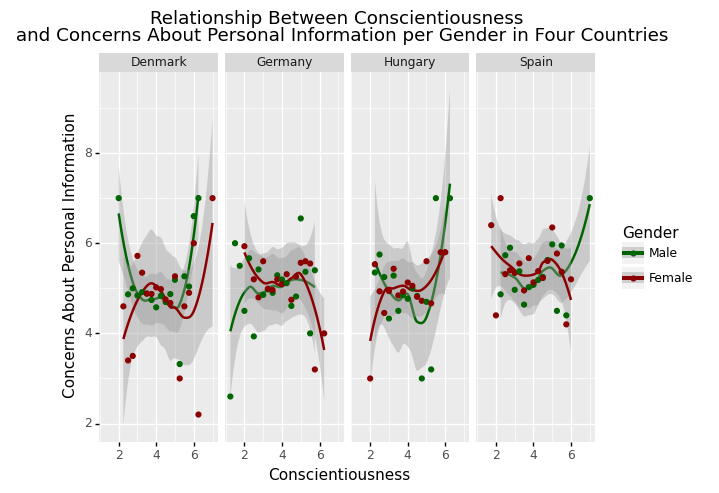

<ggplot: (8778348076147)>

In [83]:
mask = df.groupby(["conscientiousness", "gender", "country"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
# I am not goint to save this plot
(
        ggplot(mask,
               aes(x="conscientiousness",
                   y="pi_concerns",
                   color="factor(gender)")) +
        geom_smooth(method="loess", se=True) +
        geom_point() +
        facet_grid("~country") +
        xlab("Conscientiousness") +
        ylab("Concerns About Personal Information") +
        scale_color_manual(name = "Gender",
                           values=["darkgreen", "darkred"],
                           labels=["Male", "Female"]) +
        ggtitle("Relationship Between Conscientiousness \n and Concerns About Personal Information per Gender in Four Countries")
)


## 3) Structural Equation Modelling


One remark that I have to make before advancing is, *I do not make any causal claims* using the structural equation model down below. Causality requires causal model of the subject matter and statistical model alone is not enough to talk about casual relationships. Throughout this notebook I used my sociological knowledge to guide the analysis, however, it is still far from being a sound argument for causality.

Second point that I want to draw attention is structural equation models are not the only way to attack the problem. It depends on what you wish to achieve. If your task is to explain the relationships, then parametric models can be really helpful in quantifying the relationships. They are white-box models and with certain tweaks they can fit data quite well to produce a robust story. If the target is to make predictions without caring too much about the size and direction of the relationships between the exposure and the target, then predictive inference engines like decision trees, random forest, gradient boosted trees etc are really helpful. As I am interested in the relationships rather than making predictions, I want to continue with structural equation model.

This study can be conducted using multivariate regression modelling as well. The additive indeces that I created to make plots can be used as predictor variables as well. This way the problem of multicollinearity wouldn't be a problem too.

In [ ]:
df["female"] = pd.get_dummies(df["gender"],
                              drop_first=True).rename(columns={2.0:"Female"})

In [95]:
model_definition = """
    # MEASUREMENT MODEL

    ## Personality Taxonomy
    openness_l =~ open_a + open_b + open_c + open_d
    extraversion_l =~ extr_a + extr_b + extr_c + extr_d
    conscientiousness_l =~ cons_a + cons_b + cons_c + cons_d
    neuroticism_l =~ neur_a + neur_b + neur_c + neur_d
    agreeableness_l =~ agrb_a + agrb_b + agrb_c + agrb_d

    ## Political Trust
    trust_in_inst_l =~ trst_prl + trst_pol + trst_prt + trst_leg + trst_plc + trst_gov

    ## PI concerns
    pi_concerns_l =~ pi_misuse + pi_track + pi_safety + pi_share + pi_stranger

    # REGRESSION MODELS

    ## Income as function of
    income ~ female + age

    ## Personality as function of demographics
    openness_l  ~ age + income + female
    extraversion_l ~ age + income + female
    conscientiousness_l ~ age + income + female
    neuroticism_l ~ age + income + female
    agreeableness_l ~ age + income + female

    ## Trust in institutions as function of personality traits and demographics
    trust_in_inst_l ~ openness_l + extraversion_l + conscientiousness_l + neuroticism_l + agreeableness_l + female + age + income

    ### PI concerns  as function of Trust in institutions, personality traits and demographics
    pi_concerns_l ~ openness_l + extraversion_l + conscientiousness_l + neuroticism_l + agreeableness_l + trust_in_inst_l + female + age + income
"""


In [96]:
# Instantiate the model
model = sm.Model(model_definition)

# Fit the model using the data
model.fit(df)

# Show the results using the inspect method
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,income,~,female,-0.136061,0.048974,-2.778214,0.005466
1,income,~,age,-0.000271,0.001755,-0.154469,0.87724
2,openness_l,~,age,0.000535,0.001047,0.510987,0.60936
3,openness_l,~,income,0.018777,0.012719,1.476253,0.139876
4,openness_l,~,female,-0.000165,0.029261,-0.005645,0.995496
...,...,...,...,...,...,...,...
99,open_d,~~,open_d,2.137878,0.07332,29.158064,0.0
100,open_a,~~,open_a,1.971791,0.06414,30.742188,0.0
101,extr_b,~~,extr_b,1.470170,0.071379,20.596576,0.0
102,neur_a,~~,neur_a,1.462715,0.059595,24.544448,0.0


If below plot raises no graphviz module error, then you have to install python-graphviz from conda and restart the kernel

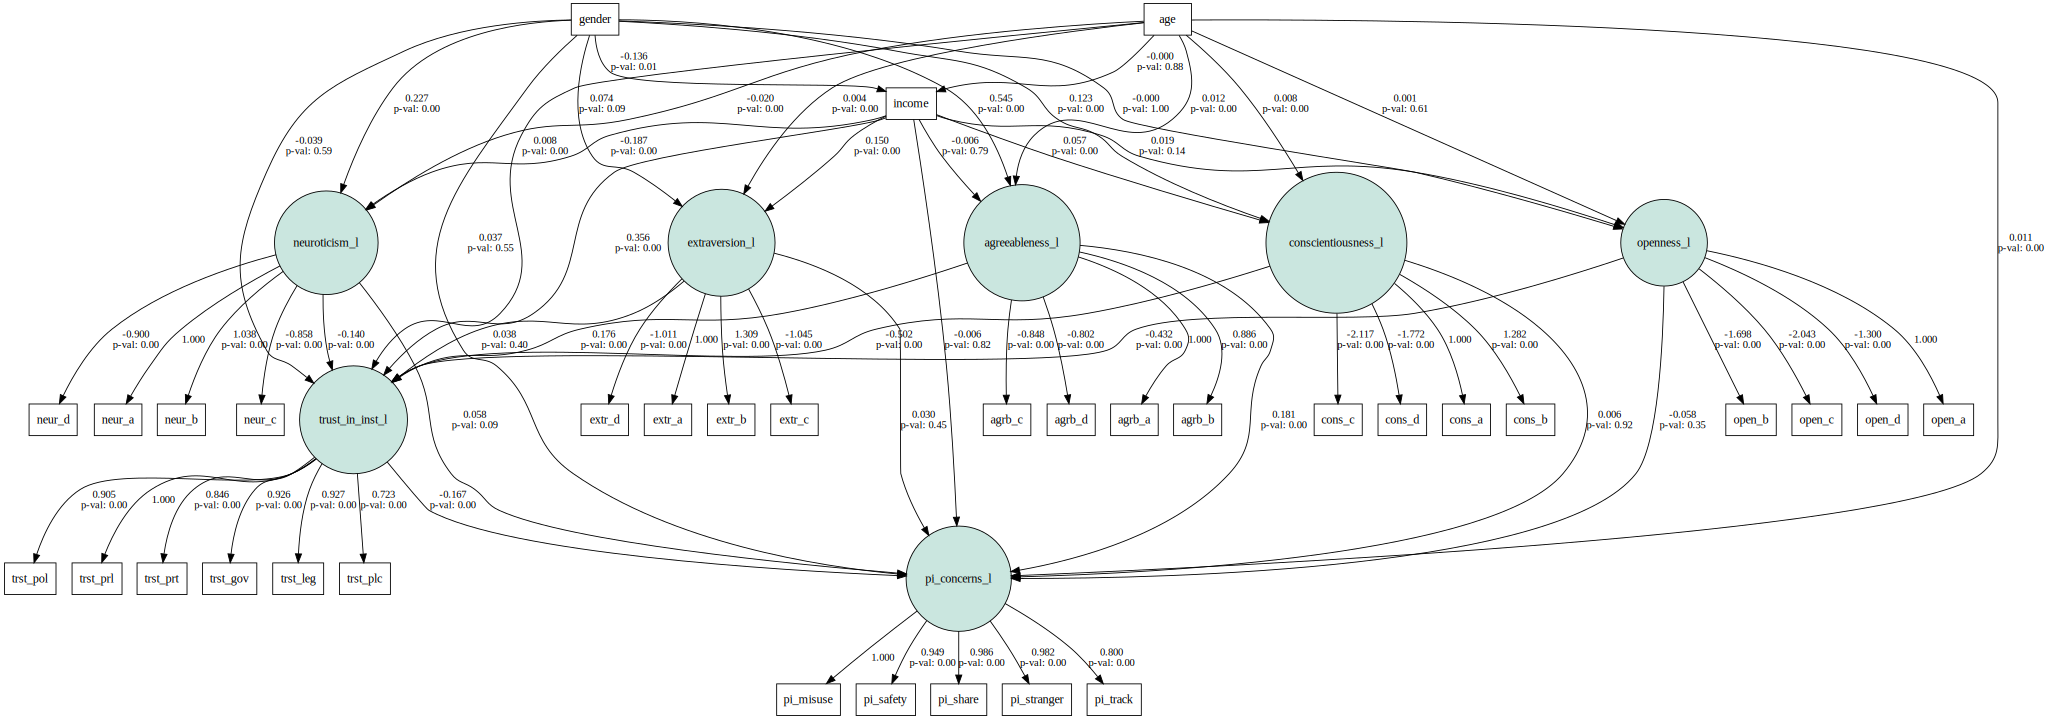

In [88]:
sm.semplot(model, "plots/sem_results.png" )

In [89]:
sm.report(model, "sem_report")

![](plots/sem_results.png)

In [ ]:
model.inspect(std_est=True)